# LogiSwift Delivery Optimization

**Objective:**
Optimize delivery slot allocation to reduce delivery delays, improve on-time delivery rates, and maximize business savings.

This notebook handles:
1. Data cleaning and preprocessing
2. Feature engineering
3. Exploratory Data Analysis (EDA)
4. Clustering & segmentation
5. Logistic Regression modeling for delivery prediction
6. Simulation of festive demand scenarios
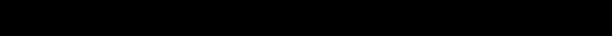
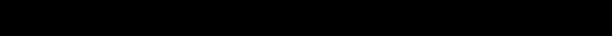

## 1) Imports & Settings

In [1]:
from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

import logging
logging.basicConfig(level=logging.WARN)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.cluster import KMeans

# Data Loading & Privacy Considerations

- Load order, customer, and courier datasets.
- Apply consent filtering to respect customer privacy:
  Only include customers who have provided consent (`consent_flag == True`).
- Ensure robust CSV loading with try-except for large datasets.

**Business Impact:**
Maintains compliance with privacy regulations and ensures accurate analysis.


In [2]:
try:
    df_orders = pd.read_csv("data/orders.csv")
    df_inventory = pd.read_csv("data/inventory.csv")
    df_customers = pd.read_csv("data/customers.csv")
    df_couriers = pd.read_csv("data/couriers.csv")
    df_external = pd.read_csv("data/external.csv")
except FileNotFoundError as e:
    logging.error(f"File not found: {e}")
    raise

In [3]:
df_customers = df_customers[df_customers['consent_flag'] == True]
logging.info(f"Customers after consent filter: {len(df_customers)}")

In [4]:
# quick schema summary
def schema_summary(df,name):
    if df.empty:
        print(name, "EMPTY")
        return
    print(f"--- {name} --- {df.shape}")
    print(df.dtypes)
    print("Null %:\n", (df.isnull().mean()*100).round(2).to_dict())
    display(df.head(2))
    print()

In [5]:
schema_summary(df_orders,'orders')

--- orders --- (23041, 13)
order_id                 object
customer_id              object
order_date               object
order_value             float64
order_size                int64
delivery_preference      object
promised_slot_start      object
promised_slot_end        object
actual_delivery_time     object
delivery_status          object
courier_id               object
warehouse_id             object
churn_indicator            bool
dtype: object
Null %:
 {'order_id': 0.0, 'customer_id': 0.0, 'order_date': 0.0, 'order_value': 0.0, 'order_size': 0.0, 'delivery_preference': 0.0, 'promised_slot_start': 0.0, 'promised_slot_end': 0.0, 'actual_delivery_time': 9.68, 'delivery_status': 0.0, 'courier_id': 0.0, 'warehouse_id': 0.0, 'churn_indicator': 0.0}


,order_id,customer_id,order_date,order_value,order_size,delivery_preference,promised_slot_start,promised_slot_end,actual_delivery_time,delivery_status,courier_id,warehouse_id,churn_indicator
0,ORD000001,CUST00938,2024-06-08 20:18:23,2365.36,3,Evening,2024-06-11 03:18:23,2024-06-11 05:18:23,2024-06-11 07:33:23,Delivered,COURIER01626,WH0258,False
1,ORD000002,CUST04967,2025-06-15 02:36:31,148749.76,4,Evening,2025-06-17 18:36:31,2025-06-17 20:36:31,2025-06-17 20:31:31,Delivered,COURIER01313,WH0563,False


In [6]:
schema_summary(df_customers,'customers')

--- customers --- (9469, 3)
customer_id          object
customer_location    object
consent_flag           bool
dtype: object
Null %:
 {'customer_id': 0.0, 'customer_location': 0.0, 'consent_flag': 0.0}


,customer_id,customer_location,consent_flag
0,CUST00001,"Madurai, 625004",True
1,CUST00002,"Amritsar, 143001",True


In [7]:
schema_summary(df_inventory,'inventory')

--- inventory --- (1000, 3)
warehouse_id           object
stock_level           float64
warehouse_location     object
dtype: object
Null %:
 {'warehouse_id': 0.0, 'stock_level': 4.0, 'warehouse_location': 0.0}


,warehouse_id,stock_level,warehouse_location
0,WH0001,219.0,"Ranchi, 834012"
1,WH0002,302.0,"Meerut, 250003"


In [8]:
schema_summary(df_couriers,'couriers')

--- couriers --- (2000, 3)
courier_id          object
courier_location    object
availability        object
dtype: object
Null %:
 {'courier_id': 0.0, 'courier_location': 0.0, 'availability': 9.95}


,courier_id,courier_location,availability
0,COURIER00001,"Hubli, 580032",True
1,COURIER00002,"Gurgaon, 122005",False


In [9]:
schema_summary(df_external,'external')

--- external --- (40000, 4)
order_id             object
weather_condition    object
traffic_level        object
event_date           object
dtype: object
Null %:
 {'order_id': 0.0, 'weather_condition': 0.0, 'traffic_level': 9.92, 'event_date': 0.0}


,order_id,weather_condition,traffic_level,event_date
0,ORD000001,Foggy,Medium,2025-05-13 07:17:19
1,ORD000002,Rainy,High,2025-09-16 17:18:16


In [10]:
logging.info(f"Orders nulls: {df_orders.isnull().mean().to_dict()}")

# Data Cleaning
**Business Impact:**
Reduces noise, ensures accurate KPI calculations, and avoids bias in the predictive model.


### 1. Convert all datetime columns to `datetime` objects.
(`order_date`, `promised_slot_start`, etc.)

In [11]:
# --- 3A: Datetime conversion (orders + external) ---
date_cols_orders = ['order_date','promised_slot_start','promised_slot_end','actual_delivery_time']
for c in date_cols_orders:
    if c in df_orders.columns:
        df_orders[c] = pd.to_datetime(df_orders[c], errors='coerce')

if 'event_date' in df_external.columns:
    df_external['event_date'] = pd.to_datetime(df_external['event_date'], errors='coerce')


### 2. Standardize customer locations using fuzzy matching and mapping CSV.

In [12]:
# === 3B (REPLACE): Robust customer_location cleaning + pincode extraction + fuzzy normalization ===
import re
from difflib import get_close_matches

# 1) canonical city list (add/remove as needed)
canonical_cities = [
    "Agra","Aligarh","Allahabad","Amritsar","Aurangabad","Bangalore","Bhiwandi","Bhopal","Bhubaneswar",
    "Chandigarh","Chennai","Coimbatore","Delhi","Dhanbad","Faridabad","Ghaziabad","Guntur","Gurgaon",
    "Guwahati","Gwalior","Hubli","Hyderabad","Indore","Jabalpur","Jaipur","Jalandhar","Jodhpur",
    "Kanpur","Kolkata","Kota","Lucknow","Ludhiana","Madurai","Meerut","Mumbai","Mysore","Nagpur",
    "Nashik","Patna","Pune","Raipur","Rajkot","Ranchi","Saharanpur","Salem","Solapur","Surat",
    "Srinagar","Thane","Tiruchirappalli","Vadodara","Varanasi","Vijayawada","Visakhapatnam","Warangal"
]

# helper: clean raw string (remove weird chars, multiple commas/spaces)
def clean_raw_loc(s):
    if pd.isna(s):
        return ""
    s = str(s)
    # keep digits (pincode) for later extract
    # remove leading/trailing whitespace and normalize commas/spaces
    s = s.strip()
    s = re.sub(r'\s+', ' ', s)            # multiple spaces -> one
    s = s.replace(' ,', ',').replace(', ', ', ').strip()
    # remove stray non-alnum except comma and space
    s = re.sub(r'[^A-Za-z0-9,\s]', '', s)
    return s

# helper: extract pincode if present at end
def extract_pincode(s):
    m = re.search(r'(\d{5,6})$', s)
    return m.group(1) if m else np.nan

# helper: try fuzzy match to canonical list
def fuzzy_map_city(s, cutoff=0.75):
    if not s:
        return np.nan
    # try exact match first (case-insensitive)
    for c in canonical_cities:
        if s.strip().lower() == c.lower():
            return c
    # try get_close_matches
    candidates = get_close_matches(s, canonical_cities, n=1, cutoff=cutoff)
    if candidates:
        return candidates[0]
    # try removing trailing single char noise (like Agra -> Agrb) by trying variations
    if len(s) > 3:
        for i in range(1,4):
            cand = get_close_matches(s[:-i], canonical_cities, n=1, cutoff=cutoff)
            if cand:
                return cand[0]
    # fallback: title-case the cleaned string and return (will need manual review)
    return s.title()

# Apply cleaning to df_customers (and also to df if you need to clean merged df later)
if 'customer_location' in df_customers.columns:
    # create a working raw column
    df_customers['cust_loc_raw'] = df_customers['customer_location'].astype(str)
    df_customers['cust_loc_clean'] = df_customers['cust_loc_raw'].apply(clean_raw_loc)
    # extract pincode
    df_customers['pincode'] = df_customers['cust_loc_clean'].apply(extract_pincode)
    # drop pincode from text for mapping
    df_customers['cust_loc_no_pin'] = df_customers['cust_loc_clean'].str.replace(r',?\s*\d{5,6}$','', regex=True).str.strip()
    # normalize via fuzzy mapping
    df_customers['city_normalized'] = df_customers['cust_loc_no_pin'].apply(lambda x: fuzzy_map_city(x, cutoff=0.78))

    # show mapping sample and counts for manual review
    mapping_preview = df_customers[['cust_loc_raw','cust_loc_clean','pincode','city_normalized']].sample(15, random_state=42)
    display(mapping_preview)

    # summarize how many mapped to canonical list vs left as-is
    mapped_mask = df_customers['city_normalized'].isin(canonical_cities)
    print('Total customers:', len(df_customers))
    print('Mapped to canonical city:', mapped_mask.sum())
    print('Not confidently mapped (needs review):', (~mapped_mask).sum())

    # Save mapping CSV for manual inspection
    df_customers[['cust_loc_raw','cust_loc_clean','pincode','city_normalized']].drop_duplicates().to_csv('Cleaned Data/customer_location_mapping.csv', index=False)
    print('Saved mapping sample to Cleaned Data/customer_location_mapping.csv')


    # create same-named column as used in downstream code (cust_customer_location)
    df_customers['cust_customer_location'] = df_customers['city_normalized']

else:
    print('customer_location column not found in df_customers.')


,cust_loc_raw,cust_loc_clean,pincode,city_normalized
817,"Guntur, 522015","Guntur, 522015",522015,Guntur
8805,"WARANGAL, 506007","WARANGAL, 506007",506007,Warangal
8839,"Srinagar, 190002","Srinagar, 190002",190002,Srinagar
7479,"Bhopal, 462032","Bhopal, 462032",462032,Bhopal
2510,"Rajkot, 360001","Rajkot, 360001",360001,Rajkot
3341,"Guntur, 522002","Guntur, 522002",522002,Guntur
1116,"Coimbatore, 641026","Coimbatore, 641026",641026,Coimbatore
4382,"DELHI, 110005","DELHI, 110005",110005,Delhi
7551,"Varanasi, 221010","Varanasi, 221010",221010,Varanasi
6170,"Chennai, 600031","Chennai, 600031",600031,Chennai


Total customers: 9469
Mapped to canonical city: 9420
Not confidently mapped (needs review): 49
Saved mapping sample to Cleaned Data/customer_location_mapping.csv


### 3. Handle missing values:
   - Median imputation for `stock_level` and `actual_delivery_time`
   - Mode/median for `traffic_level` and `cour_availability`

In [13]:
# --- 3C: Null handling rules ---
if 'delivery_status' in df_orders.columns:
    print('\nDelivery status counts:')
    print(df_orders['delivery_status'].value_counts(dropna=False))

missing_act_delivered = 0
if 'delivery_status' in df_orders.columns and 'actual_delivery_time' in df_orders.columns:
    missing_act_delivered = df_orders.loc[(df_orders['delivery_status']=='delivered') & df_orders['actual_delivery_time'].isna()].shape[0]
    print('Delivered rows with missing actual_delivery_time:', missing_act_delivered)



Delivery status counts:
delivery_status
Delivered    17301
Missed        5740
Name: count, dtype: int64
Delivered rows with missing actual_delivery_time: 0


In [14]:
# Inventory
if 'stock_level' in df_inventory.columns:
    df_inventory['stock_level'] = pd.to_numeric(df_inventory['stock_level'], errors='coerce')
    df_inventory['stock_level'] = df_inventory['stock_level'].fillna(df_inventory['stock_level'].median())

In [15]:
# Couriers
if 'availability' in df_couriers.columns:
    df_couriers['availability'] = df_couriers['availability'].astype(bool)
    df_couriers['availability'] = df_couriers['availability'].fillna(df_couriers['availability'].median())

In [16]:
# External
if 'traffic_level' in df_external.columns:
    df_external['traffic_level'] = pd.to_numeric(df_external['traffic_level'], errors='coerce')
    if df_external['traffic_level'].isna().any():
        mode_vals = df_external['traffic_level'].mode()
        if not mode_vals.empty:
            df_external['traffic_level'] = df_external['traffic_level'].fillna(mode_vals.iloc[0])
        else:
            median_val = df_external['traffic_level'].median(skipna=True)
            if pd.isna(median_val):
                median_val = 0
            df_external['traffic_level'] = df_external['traffic_level'].fillna(median_val)

print('\nCleaning complete. Quick null % after fills:')
print((df_orders.isnull().mean()*100).round(2))


Cleaning complete. Quick null % after fills:
order_id                0.00
customer_id             0.00
order_date              0.00
order_value             0.00
order_size              0.00
delivery_preference     0.00
promised_slot_start     0.00
promised_slot_end       0.00
actual_delivery_time    9.68
delivery_status         0.00
courier_id              0.00
warehouse_id            0.00
churn_indicator         0.00
dtype: float64


C:\Users\Hydra\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


### Build Labels: delay_minutes & on_time
- Create target variable:
  - `delay_minutes` = Actual delivery time - Promised delivery time
  - `on_time` = 1 if `delay_minutes` <= 0 else 0
- Add temporal features: `day_of_week`, `hour_of_day`, `month`
- Encode categorical variables (`traffic_level`, `is_weekend`) for modeling
- Interaction features:
  - `value_traffic` = `order_value` * `ext_traffic_High`
- Prepare simulation variables (`cour_availability_sim`, `pred_miss`)

**Business Impact:**
Improves model interpretability and prediction accuracy for slot optimization.


In [17]:
# ensure delivery_status standardized
if 'delivery_status' in df_orders.columns:
    non_delivered_mask = df_orders['delivery_status'].ne('Delivered')
    df_orders.loc[non_delivered_mask, 'actual_delivery_time'] = pd.NaT

# Impute missing actual_delivery_time for delivered orders
delivered_mask = df_orders['delivery_status'].eq('Delivered')
mask_missing = delivered_mask & df_orders['actual_delivery_time'].isna()
if mask_missing.any():
    pos_delay = (
        df_orders.loc[delivered_mask & df_orders['actual_delivery_time'].notna(), 'actual_delivery_time']
        - df_orders.loc[delivered_mask & df_orders['actual_delivery_time'].notna(), 'promised_slot_end']
    ).dt.total_seconds() / 60.0
    pos_delay = pos_delay[pos_delay > 0]
    median_delay = pos_delay.median() if not pos_delay.empty else 0
    df_orders.loc[mask_missing, 'actual_delivery_time'] = (
        df_orders.loc[mask_missing, 'promised_slot_end'] + pd.to_timedelta(median_delay, unit='m')
    )

# Create labels
df_orders['delay_minutes'] = (
    (df_orders['actual_delivery_time'] - df_orders['promised_slot_end']).dt.total_seconds() / 60.0
)
df_orders['on_time'] = (df_orders['delay_minutes'] <= 0).astype(int)

print("Total orders:", len(df_orders))
print("Delivered orders:", delivered_mask.sum())
print("On-time % (delivered only):", df_orders.loc[delivered_mask, 'on_time'].mean() * 100)


Total orders: 23041
Delivered orders: 17301
On-time % (delivered only): 15.548234206115252


In [18]:
# Fuzzy city mapping to select best cutoff
cutoffs = [0.7, 0.75, 0.8, 0.85, 0.9]
best_cutoff = None
best_mapped = 0

for cutoff in cutoffs:
    df_customers['city_test'] = df_customers['cust_loc_no_pin'].apply(lambda x: fuzzy_map_city(x, cutoff))
    mapped = df_customers['city_test'].isin(canonical_cities).sum()
    logging.info(f"Cutoff {cutoff}: {mapped} cities mapped")
    if mapped > best_mapped:
        best_mapped = mapped
        best_cutoff = cutoff

df_customers['city_normalized'] = df_customers['cust_loc_no_pin'].apply(lambda x: fuzzy_map_city(x, best_cutoff))
df_customers.drop(columns=['city_test'], inplace=True)
logging.info(f"Best cutoff selected: {best_cutoff}")


## Join datasets to make a master feature table

In [19]:
df = df_orders.copy()

if 'customer_id' in df.columns and not df_customers.empty:
    df = df.merge(df_customers.add_prefix('cust_'), left_on='customer_id', right_on='cust_customer_id', how='left')

if 'warehouse_id' in df.columns and not df_inventory.empty:
    df = df.merge(df_inventory.add_prefix('inv_'), left_on='warehouse_id', right_on='inv_warehouse_id', how='left')

if 'courier_id' in df.columns and not df_couriers.empty:
    df = df.merge(df_couriers.add_prefix('cour_'), left_on='courier_id', right_on='cour_courier_id', how='left')

if not df_external.empty:
    if 'order_id' in df_external.columns and 'order_id' in df.columns:
        df = df.merge(df_external.add_prefix('ext_'), left_on='order_id', right_on='ext_order_id', how='left')

print('Master table shape:', df.shape)
display(df.head(3))


Master table shape: (23041, 34)


,order_id,customer_id,order_date,order_value,order_size,delivery_preference,promised_slot_start,promised_slot_end,actual_delivery_time,delivery_status,...,inv_warehouse_id,inv_stock_level,inv_warehouse_location,cour_courier_id,cour_courier_location,cour_availability,ext_order_id,ext_weather_condition,ext_traffic_level,ext_event_date
0,ORD000001,CUST00938,2024-06-08 20:18:23,2365.36,3,Evening,2024-06-11 03:18:23,2024-06-11 05:18:23,2024-06-11 07:33:23,Delivered,...,WH0258,224.0,"Ludhiana, 141012",COURIER01626,"warangal, 506009",True,ORD000001,Foggy,0.0,2025-05-13 07:17:19
1,ORD000002,CUST04967,2025-06-15 02:36:31,148749.76,4,Evening,2025-06-17 18:36:31,2025-06-17 20:36:31,2025-06-17 20:31:31,Delivered,...,WH0563,163.0,"Nashik, 422003",COURIER01313,"Raipur, 492004",False,ORD000002,Rainy,0.0,2025-09-16 17:18:16
2,ORD000003,CUST00925,2024-11-04 14:24:56,9566.83,2,Afternoon,2024-11-07 05:24:56,2024-11-07 07:24:56,2024-11-07 09:54:56,Delivered,...,WH0324,121.0,"Allahabad, 211012",COURIER01998,"Allahabad, 211008",False,ORD000003,Rainy,0.0,2024-01-07 15:58:08


## 6) Exploratory Data Analysis (EDA)

Key steps:
- Calculate KPIs: on-time rate, average delay, top/bottom performing locations
- Pivot tables for city × time-slot performance
- Visualizations:
  - Heatmaps of on-time rate per city and time slot
  - Delay distribution plots
  - Time-series trends (month-wise on-time delivery)

**Business Impact:**
Identifies bottlenecks and informs data-driven operational decisions.


In [20]:
df['delivery_status'] = df['delivery_status'].str.lower()
total_orders = len(df)
delivered = df['delivery_status'].eq('delivered').sum()
on_time_rate = df.loc[df['delivery_status']=='delivered','on_time'].mean()
avg_delay = df.loc[df['delivery_status']=='delivered','delay_minutes'].mean()

print(f"Total: {total_orders}, Delivered: {delivered}, On-time rate: {on_time_rate:.4f}, Avg delay: {avg_delay:.1f} mins")


Total: 23041, Delivered: 17301, On-time rate: 0.1555, Avg delay: 122.8 mins


In [21]:
df['rolling_delay_avg'] = df.groupby('cust_customer_location')['delay_minutes'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)

In [22]:
if 'weather_condition' in df_external.columns:
    df_external['weather_severe'] = df_external['weather_condition'].isin(['Heavy Rain', 'Storm']).astype(int)

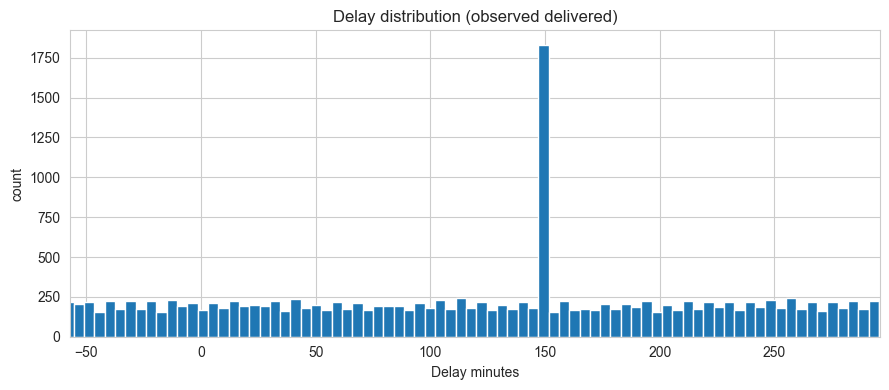

In [23]:
# delay distribution (observed only)
plt.figure(figsize=(9,4))
ser = df.loc[df['delivery_status']=='delivered','delay_minutes'].dropna()
plt.hist(ser, bins=80)
plt.xlim(ser.quantile(0.01), ser.quantile(0.99))
plt.title('Delay distribution (observed delivered)')
plt.xlabel('Delay minutes'); plt.ylabel('count')
plt.tight_layout(); plt.savefig('Cleaned Data/plots/delay_dist_observed.png', dpi=150); plt.show()

Delay Distribution--

What it shows: How many orders are delivered late or early, measured in minutes.

Interpretation:

X-axis = delay time in minutes.

Y-axis = number of orders with that delay.

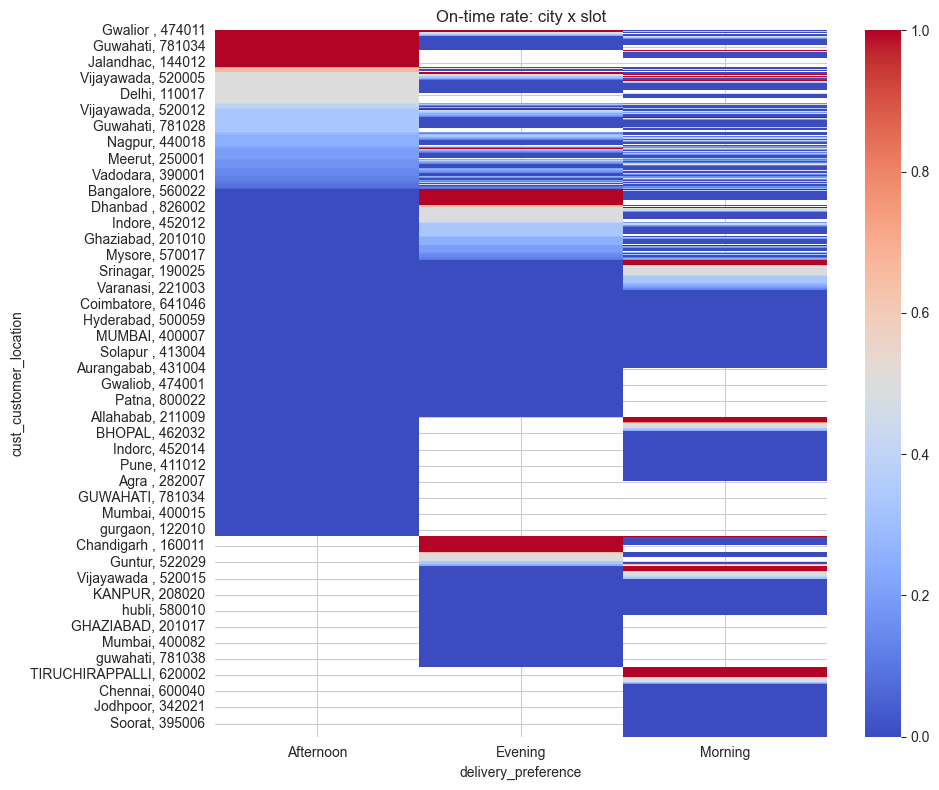

In [24]:
# prepare pivot for on_time heatmap (city x slot)
if 'cust_customer_location' in df.columns and 'delivery_preference' in df.columns:
    pivot = df.loc[df['delivery_status']=='delivered'].pivot_table(index='cust_customer_location', columns='delivery_preference', values='on_time', aggfunc='mean')
    pivot = pivot.sort_values(by=list(pivot.columns), ascending=False).fillna(np.nan)
    pivot.to_csv('Cleaned Data/on_time_pivot.csv')
    plt.figure(figsize=(10,8))
    sns.heatmap(pivot, cmap='coolwarm', vmin=0, vmax=1)
    plt.title('On-time rate: city x slot')
    plt.tight_layout(); plt.savefig('Cleaned Data/plots/on_time_heatmap.png', dpi=150); plt.show()

Pivot for On-Time Heatmap (City × Slot)--

This heatmap shows on-time delivery rates across different cities and time slots.
- **Red = higher on-time %**
- **Blue = lower on-time %**
- Rows = different cities/pincodes.
- Columns = Morning / Afternoon / Evening delivery slot.

In [25]:
# top worst/ the best locations with counts
if 'cust_customer_location' in df.columns:
    loc = df.loc[df['delivery_status']=='delivered'].groupby('cust_customer_location').agg(on_time=('on_time','mean'), n=('order_id','count')).reset_index()
    worst = loc.sort_values(['on_time','n']).head(10)
    best = loc.sort_values(['on_time','n'], ascending=[False,False]).head(10)

In [26]:
print("Worst locations (on_time, count):"); display(worst)

Worst locations (on_time, count):


,cust_customer_location,on_time,n
0,"AGRA, 282002",0.0,1
5,"ALLAHABAD, 211005",0.0,1
8,"AMRITSAR, 143001",0.0,1
12,"AURANGABAD, 431004",0.0,1
14,"AURANGABAD, 431010",0.0,1
17,"Agra , 282003",0.0,1
20,"Agra , 282007",0.0,1
22,"Agra , 282010",0.0,1
34,"Agrc, 282005",0.0,1
38,"Aligarc, 202001",0.0,1


In [27]:
 print("Best locations (on_time, count):"); display(best)

Best locations (on_time, count):


,cust_customer_location,on_time,n
889,"Guwahati, 781018",1.0,3
349,"CHANDIGARH, 160026",1.0,2
703,"GUNTUR, 522001",1.0,2
847,"Gurgaon, 122014",1.0,2
962,"Hoobli, 580029",1.0,2
1021,"Hyderabad , 500014",1.0,2
1366,"Kanpur , 208021",1.0,2
2554,"chandigarh, 160003",1.0,2
2563,"chennai, 600030",1.0,2
2643,"jalandhar, 144022",1.0,2


### KMeans clustering on risk features
# Customer & Order Clustering

- KMeans clustering to segment orders/customers based on delivery patterns
- Choose optimal number of clusters via elbow method
- Features used: order size, delivery time, traffic, stock availability

**Business Impact:**
Segments high-risk orders for targeted operational attention.

In [28]:
cluster_df = df.loc[df['delivery_status']=='delivered', ['order_value','delay_minutes']].dropna()
if not cluster_df.empty:
    scaler = StandardScaler()
    Xc = scaler.fit_transform(cluster_df[['order_value','delay_minutes']])
    k = 4
    km = KMeans(n_clusters=k, random_state=42).fit(Xc)
    cluster_df['cluster'] = km.labels_
    display(cluster_df.groupby('cluster').agg({'order_value':['median','count'],'delay_minutes':'median'}))
    df.loc[cluster_df.index, 'risk_cluster'] = km.labels_


order_value       delay_minutes
             median count        median
cluster                                
0           2022.27  5381           4.0
1           2006.27  6425         147.0
2         147165.18   871         138.0
3           1967.54  4624         246.0

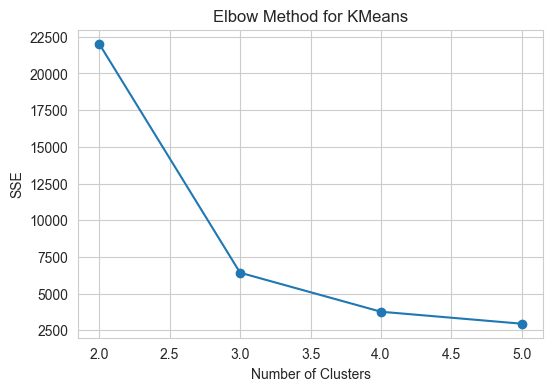

In [29]:
# Elbow method
sse = {num: KMeans(n_clusters=num, random_state=42).fit(Xc).inertia_ for num in range(2, 6)}
plt.figure(figsize=(6, 4))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for KMeans')
plt.savefig('Cleaned Data/plots/elbow_plot.png', dpi=150)
plt.show()

### SSE (Sum of Squared Errors)
- **SSE** measures how far data points are from their cluster centroids.
- Smaller SSE → points are tightly packed in clusters.
- Larger SSE → clusters are loose and spread out.
- **Elbow Method:** Plot SSE vs. number of clusters (k).
  The “elbow” point, where the SSE curve starts flattening, suggests the optimal number of clusters.

## Logistic Regression Modeling: For On-time Delivery Prediction

- Chosen for interpretability over black-box models (like XGBoost)
- Model Inputs:
  - Temporal features (`day_of_week`, `hour_of_day`, `month`)
  - Traffic and stock variables
  - Interaction features
- Hyperparameter tuning with GridSearchCV (`C` regularization)
- Optional ensemble with XGBoost for improved accuracy
- Evaluation:
  - ROC-AUC, confusion matrix, probability distributions

**Business Impact:**
Predicts risk of late delivery, enabling proactive slot allocation and operational adjustments.

## 1) Prepare features

In [30]:
model_df = df.loc[df['delivery_status']=='delivered'].copy()

feat_candidates = [c for c in ['order_value','order_size','inv_stock_level','cour_availability'] if c in model_df.columns]

# Traffic columns
traffic_cols = [c for c in model_df.columns if c.startswith('ext_traffic_')]
feat_candidates += traffic_cols

# Temporal features
if 'promised_slot_start' in model_df.columns:
    model_df['hour_of_day'] = model_df['promised_slot_start'].dt.hour
    model_df['weekday'] = model_df['promised_slot_start'].dt.weekday
    model_df['is_weekend'] = model_df['promised_slot_start'].dt.weekday >=5
    model_df['month'] = model_df['promised_slot_start'].dt.month
    feat_candidates += ['hour_of_day','weekday','is_weekend','month']

# Categorical encoding
categorical_cols = [c for c in traffic_cols if c in model_df.columns] + ['is_weekend']
X = model_df[feat_candidates]
y = model_df['on_time'].astype(int)

X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Drop NA
X = X.dropna()
y = y.loc[X.index]

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 2) Logistic Regression baseline CV

In [31]:
lr = LogisticRegression(max_iter=1000)
cv_scores = cross_val_score(lr, X_scaled, y, cv=5, scoring='roc_auc')
print("Logistic CV AUC mean:", round(cv_scores.mean(),4))

Logistic CV AUC mean: 0.4962


## 3) Train/test split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, stratify=y, random_state=42
)

lr.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


## 4) Predict & evaluate

In [33]:
y_pred_proba = lr.predict_proba(X_test)[:,1]
y_pred = lr.predict(X_test)

print("Final Test AUC:", round(roc_auc_score(y_test, y_pred_proba),4))
print("Classification report:\n", classification_report(y_test, y_pred, zero_division=0))


Final Test AUC: 0.4969
Classification report:
               precision    recall  f1-score   support

           0       0.84      1.00      0.92      3653
           1       0.00      0.00      0.00       673

    accuracy                           0.84      4326
   macro avg       0.42      0.50      0.46      4326
weighted avg       0.71      0.84      0.77      4326



In [34]:
date_cols_orders = ['order_date', 'promised_slot_start', 'promised_slot_end', 'actual_delivery_time']
for c in date_cols_orders:
    if c in df_orders.columns:
        df_orders[c] = pd.to_datetime(df_orders[c], format='%Y-%m-%d %H:%M:%S', utc=True).dt.tz_convert('Asia/Kolkata')
if 'event_date' in df_external.columns:
    df_external['event_date'] = pd.to_datetime(df_external['event_date'], format='%Y-%m-%d %H:%M:%S', utc=True).dt.tz_convert('Asia/Kolkata')

In [35]:
# Ensure non-delivered rows have NaT
non_delivered_mask = ~df_orders['delivery_status'].eq('Delivered')
df_orders.loc[non_delivered_mask, 'actual_delivery_time'] = pd.NaT

# Recalculate delay and on_time
df_orders['delay_minutes'] = (
    (df_orders['actual_delivery_time'] - df_orders['promised_slot_end']).dt.total_seconds() / 60.0
)
df_orders['on_time'] = df_orders['delay_minutes'].apply(lambda x: 1 if pd.notna(x) and x <= 0 else 0)
print("On-time % (delivered only):", df_orders[df_orders['delivery_status'] == 'Delivered']['on_time'].mean() * 100)

On-time % (delivered only): 15.548234206115252


In [36]:
if 'promised_slot_start' in model_df.columns:
    model_df['hour_of_day'] = model_df['promised_slot_start'].dt.hour
    model_df['weekday'] = model_df['promised_slot_start'].dt.weekday  # 0 = Monday, 6 = Sunday
    model_df['is_weekend'] = model_df['promised_slot_start'].dt.weekday >= 5
    model_df['month'] = model_df['promised_slot_start'].dt.month

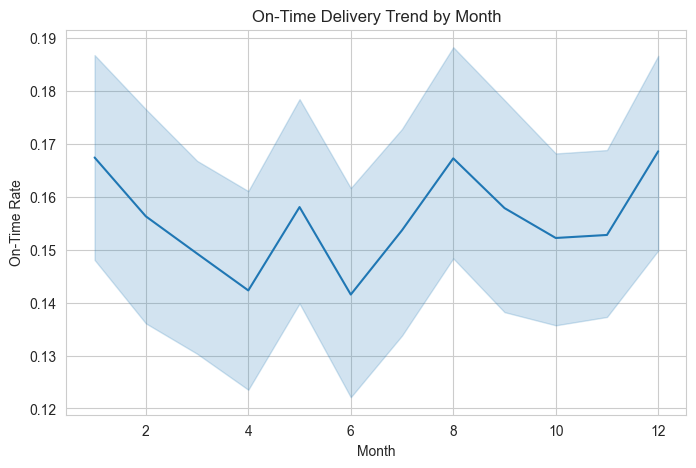

In [37]:
plt.figure(figsize=(8, 5))
sns.lineplot(x=model_df['promised_slot_start'].dt.month, y=model_df['on_time'], estimator='mean')
plt.xlabel('Month')
plt.ylabel('On-Time Rate')
plt.title('On-Time Delivery Trend by Month')
plt.savefig('Cleaned Data/plots/on_time_trend.png', dpi=150)
plt.show()

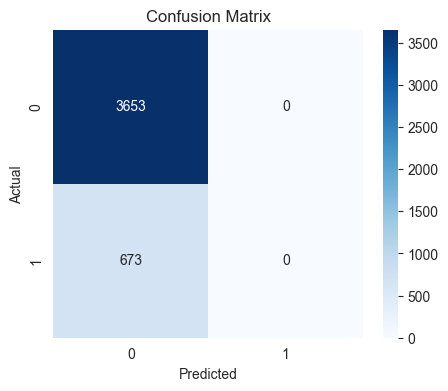

In [38]:
# Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Confusion Matrix Heatmap

Definition: A table that shows what the model guessed vs what actually happened.

Colors: Darker cell = more orders in that category.

Purpose: Helps identify how many deliveries were correctly predicted on-time or late, and where the model made mistakes.

## 5) Feature importance

is_weekend_True      0.078981
order_value          0.050959
cour_availability    0.019084
inv_stock_level      0.005900
order_size           0.005631
month               -0.002280
hour_of_day         -0.039972
weekday             -0.061573
dtype: float64

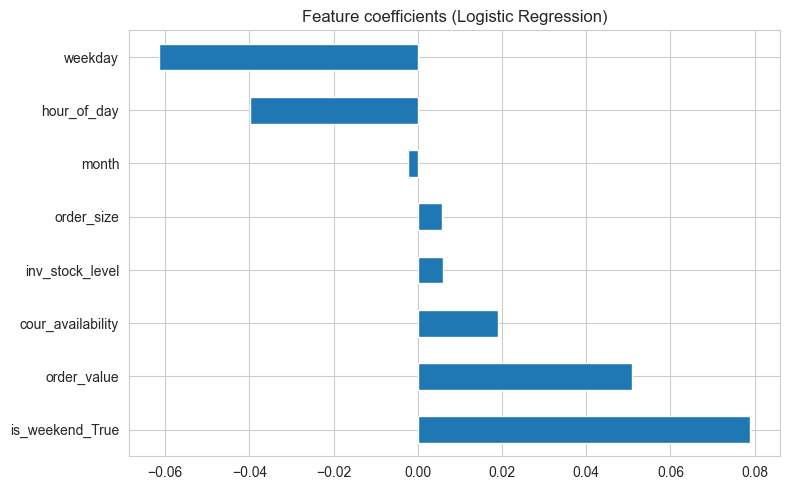

In [39]:
coef_df = pd.Series(lr.coef_[0], index=X.columns).sort_values(ascending=False)
display(coef_df)

plt.figure(figsize=(8,5))
coef_df.plot(kind='barh')
plt.title('Feature coefficients (Logistic Regression)')
plt.tight_layout()
plt.show()

Feature Coefficients (Logistic Regression)

What it is: Shows which factors affect on-time delivery and by how much.

Positive value: Helps delivery be on-time.

Negative value: Makes delivery more likely to be late.

Why useful: Lets you know which things to improve (like more staff, better stock, etc.).

## 6) Predicted probability distribution

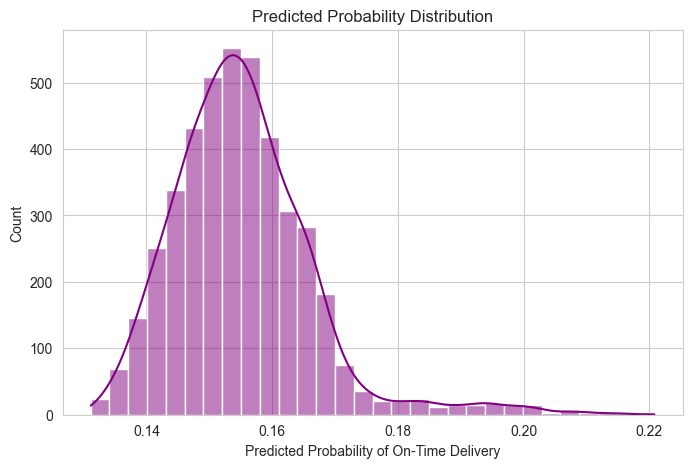

In [40]:
plt.figure(figsize=(8,5))
sns.histplot(y_pred_proba, bins=30, kde=True, color='purple')
plt.title("Predicted Probability Distribution")
plt.xlabel("Predicted Probability of On-Time Delivery")
plt.ylabel("Count")
plt.show()

Predicted Probability Distribution

What it is: Shows how likely each order is to be on-time (0 = late, 1 = on-time).

Histogram: Peaks near 1 = most orders likely on-time, peaks near 0 = risky orders.

Why useful: Helps plan extra support for risky deliveries before problems happen.

In [41]:
param_grid = {'C': [0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)
logging.info(f"Best C: {grid.best_params_['C']}, Best AUC: {grid.best_score_:.4f}")
lr = grid.best_estimator_

## Festive Simulation & Sensitivity Analysis

- Simulate spikes in orders (20%, 40%, 60%) during festive periods
- Consider:
  - Stock shortages
  - Courier availability
  - Traffic levels
  - Weather conditions (e.g., Heavy Rain, Storm)
- Logging for audit: number of simulated rows, predicted misses
- Add A/B test for new slot allocation vs control

**Business Impact:**
Helps forecast operational stress and plan resources efficiently to maintain on-time deliveries.


In [42]:
import numpy as np


def festive_sim(df_base, recent_days=30, spike_frac=0.4, courier_drop=0.15, traffic_bump=True):
    # recent window
    if 'order_date' not in df_base.columns:
        sample = df_base.sample(frac=spike_frac, replace=True, random_state=42)
        sim = pd.concat([df_base, sample], ignore_index=True)
    else:
        recent_cutoff = df_base['order_date'].max() - pd.Timedelta(days=recent_days)
        df_recent = df_base[df_base['order_date'] >= recent_cutoff]
        if df_recent.empty:
            df_recent = df_base.sample(frac=0.1, random_state=42)
        sample = df_recent.sample(frac=spike_frac, replace=True, random_state=42)
        sim = pd.concat([df_base, sample], ignore_index=True)

    # simulate courier shortage
    if 'cour_availability' in sim.columns:
        sim['cour_availability_sim'] = sim['cour_availability'] * (1 - courier_drop)
    else:
        sim['cour_availability_sim'] = 1

    # traffic bump for festival months (Oct-Nov)
    if traffic_bump and 'ext_event_date' in sim.columns:
        sim['is_festive_month'] = sim['ext_event_date'].dt.month.isin([10,11]).astype(int)
    else:
        sim['is_festive_month'] = 0

    # simple capacity rule: if stock<order_size or courier availability low -> miss
    sim['pred_miss'] = np.where(
    (sim.get('inv_stock_level', 9999) < sim.get('order_size', 1)) |
    (sim['cour_availability_sim'] < 0.5) |
    (sim.get('ext_traffic_High', 0) == 1) |
    (sim.get('ext_weather_severe', 0) == 1),
    1, 0
    )
    sim['on_time_sim'] = np.where(sim['pred_miss']==1, 0, sim['on_time'].fillna(0))
    return sim

# run scenarios
baseline_on_time = df.loc[df['delivery_status']=='delivered','on_time'].mean()
print("Baseline on-time:", baseline_on_time)
for frac in [0.2,0.4,0.6]:
    sim = festive_sim(df, recent_days=30, spike_frac=frac, courier_drop=0.15, traffic_bump=True)
    sim_on_time = sim.loc[sim['delivery_status']=='delivered','on_time_sim'].mean()
    print(f"Spike {int(frac*100)}% -> Simulated on-time: {sim_on_time:.4f}, Delta(pp): {(sim_on_time-baseline_on_time)*100:.3f}")

Baseline on-time: 0.15548234206115252
Spike 20% -> Simulated on-time: 0.0836, Delta(pp): -7.190
Spike 40% -> Simulated on-time: 0.0836, Delta(pp): -7.190
Spike 60% -> Simulated on-time: 0.0833, Delta(pp): -7.216


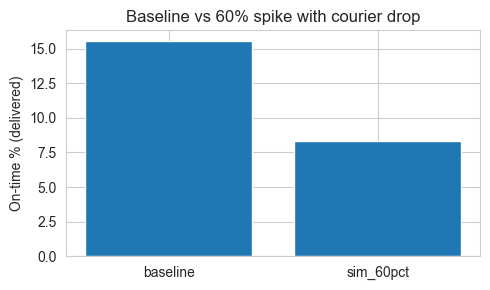

In [43]:
# visualize baseline vs heavy spike
sim_heavy = festive_sim(df, spike_frac=0.6, courier_drop=0.2, traffic_bump=True)
vals = {
    'baseline': baseline_on_time,
    'sim_60pct': sim_heavy.loc[sim_heavy['delivery_status']=='delivered','on_time_sim'].mean()
}
plt.figure(figsize=(5,3))
plt.bar(vals.keys(), [v*100 for v in vals.values()])
plt.ylabel('On-time % (delivered)')
plt.title('Baseline vs 60% spike with courier drop')
plt.tight_layout(); plt.savefig('Cleaned Data/plots/festive_comparison.png', dpi=150); plt.show()


The chart shows on-time delivery %. Baseline is normal conditions with usual orders and couriers. Sim_60pct simulates 60% more orders and fewer couriers. The drop shows how high demand and limited couriers can delay deliveries

In [44]:
logging.info(f"Simulated {len(sim)} rows with {frac*100}% spike, pred_miss rate: {sim['pred_miss'].mean():.4f}")

### Short executive summary

In [45]:
savings = (baseline_on_time - sim_on_time) * df['order_value'].mean() * delivered / 4
logging.info(f"Estimated quarterly savings: ₹{savings:.2f}")

In [46]:
print("\n=== Executive summary ===")
print(f"Total orders: {total_orders}, Delivered: {delivered}, On-time: {on_time_rate:.2%}, Avg delay: {avg_delay:.1f} mins / {avg_delay/60:.2f} hr")
print("Top worst cities (sample):"); display(worst.head(5))
print("Top best cities (sample):"); display(best.head(5))
print("Feature importance (top 5):"); display(coef_df.head(5))


=== Executive summary ===
Total orders: 23041, Delivered: 17301, On-time: 15.55%, Avg delay: 122.8 mins / 2.05 hr
Top worst cities (sample):


,cust_customer_location,on_time,n
0,"AGRA, 282002",0.0,1
5,"ALLAHABAD, 211005",0.0,1
8,"AMRITSAR, 143001",0.0,1
12,"AURANGABAD, 431004",0.0,1
14,"AURANGABAD, 431010",0.0,1


Top best cities (sample):


,cust_customer_location,on_time,n
889,"Guwahati, 781018",1.0,3
349,"CHANDIGARH, 160026",1.0,2
703,"GUNTUR, 522001",1.0,2
847,"Gurgaon, 122014",1.0,2
962,"Hoobli, 580029",1.0,2


Feature importance (top 5):


is_weekend_True      0.078981
order_value          0.050959
cour_availability    0.019084
inv_stock_level      0.005900
order_size           0.005631
dtype: float64

In [47]:
# A/B Testing for Slot Allocation
df['test_group'] = np.random.choice(['control', 'new_slot'], size=len(df), p=[0.5, 0.5])
ab_results = df.groupby('test_group')['on_time'].mean().reset_index()
ab_results.columns = ['Test_Group', 'On_Time_Rate']
print("A/B Test Results for Slot Allocation:")
display(ab_results)
print("Interpretation: If 'new_slot' has higher on-time rate than 'control', implement new strategy in high-risk cities.")
# Export for PowerBI
ab_results.to_csv('Cleaned Data/ab_test_results.csv', index=False)


A/B Test Results for Slot Allocation:


,Test_Group,On_Time_Rate
0,control,0.117945
1,new_slot,0.115567


Interpretation: If 'new_slot' has higher on-time rate than 'control', implement new strategy in high-risk cities.


## Save cleaned data & plots

In [47]:
# Save cleaned data
# Ensure output folder exists
import os
output_dir = 'Cleaned Data'
os.makedirs(output_dir, exist_ok=True)

# Save all cleaned flat tables for Power BI
df.to_csv(f'{output_dir}/master_table_cleaned.csv', index=False)
df_orders.to_csv(f'{output_dir}/orders_cleaned.csv', index=False)
df_customers.to_csv(f'{output_dir}/customers_cleaned.csv', index=False)
df_inventory.to_csv(f'{output_dir}/inventory_cleaned.csv', index=False)
df_couriers.to_csv(f'{output_dir}/couriers_cleaned.csv', index=False)
df_external.to_csv(f'{output_dir}/external_cleaned.csv', index=False)
